<a href="https://colab.research.google.com/github/DSQUEST100/PG_AI_public/blob/main/Projekt_Redukcja_Wymiarowo%C5%9Bci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wprowadzenie do projektu

**Celem projektu** jest porównanie metod redukcji wymiarowości i ich wpływu na wyniki treningu modelu klasyfikacyjnego.

Spodziewanymi korzyściami z redukcji wymiarowości są:
1. poprawa wskaźników jakości modelu
2. zmniejszenie skłonności modelu do przeuczenia (eliminacja mniej ważnych cech oraz szumu informacyjnego)
3. zmniejszenie obciążenia sprzętowego (mniejsza ilość danych)


**Zestaw danych w projekcie:**  
Link do zestawu: https://www.kaggle.com/datasets/stealthtechnologies/predict-bankruptcy-in-poland
Zbiór danych zawiera informacje finansowe (64 metryki) wykorzystywane do prognozowania upadłości wśród polskich przedsiębiorstw. Dane zostały zgromadzone z serwisu Emerging Markets Information Service (EMIS, http://www.securities.com) i dotyczą okresu od 2000 do 2013 roku.

**Kryteria oceny modelu**  
W ocenie modelu przyjmuję perspektywę inwestora którego głównym celem jest ograniczenie ryzyka utraty kapitału w wyniku upadku przedsiębiorstw w które zainwestował.

Dlatego kluczowymi wynikami oceny efektów będą 3 obszary:

1. Wskaźniki jakości modelu
- recall czyli zdolność skutecznego wykrywania wszystkich bankrutów
- precision - ocena ma złożony charakter bo akceptuję fałszywe alarmy gdyż taka informacja jest cenna wskazując firmy które z różnych powodów będą radziły sobie słabo więc inwestowanie w nie może być nieopłacalne i/lub ryzykowne, natomiast zbyt niska precyzja ograniczy możliwości zarabiania
- F1 Score pomoże zważyć recall do precision i podjąć decyzję
  
2. Skłonność modelu do przeuczenia/niedouczenia
- dane pozbawione mniej istotnych cech i szumu będą ograniczały przeuczenie

3. Czas i koszty treningu
- wskaźniki obciążenia hardware (CPU i RAM)
- czas treningu (najmniej ważny, to bardziej z ciekawości)


**Struktura projektu:**
1. Exploratory Data Analysis
2. Przeprowadzenie redukcji i przygotowanie zestawów danych
   - manualna
   - feature importance
   - PCA
   - autoencoder
4. Trening modelu
5. Analiza wyników


## Import modułów

In [ ]:
### Paczki podstawowe:
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import time
import psutil
import os

### Paczki ML:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

# Exploratory Data Analysis

## Import zestawu

In [ ]:
# Download latest version
path = kagglehub.dataset_download("stealthtechnologies/predict-bankruptcy-in-poland")

# Wczytaj plik CSV do DataFrame
original_data = pd.read_csv(f"{path}/data.csv")
#original_data = pd.read_csv('/home/b/Desktop/Predict_Bankruptcy_in_Poland.csv')

## Wstępna analiza zestawu

In [ ]:
original_data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A57,A58,A59,A60,A61,A62,A63,A64,class,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,1


In [ ]:
original_data.shape

(43405, 66)

In [ ]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      43397 non-null  float64
 1   A2      43397 non-null  float64
 2   A3      43397 non-null  float64
 3   A4      43271 non-null  float64
 4   A5      43316 non-null  float64
 5   A6      43397 non-null  float64
 6   A7      43397 non-null  float64
 7   A8      43311 non-null  float64
 8   A9      43396 non-null  float64
 9   A10     43397 non-null  float64
 10  A11     43361 non-null  float64
 11  A12     43271 non-null  float64
 12  A13     43278 non-null  float64
 13  A14     43397 non-null  float64
 14  A15     43369 non-null  float64
 15  A16     43310 non-null  float64
 16  A17     43311 non-null  float64
 17  A18     43397 non-null  float64
 18  A19     43277 non-null  float64
 19  A20     43278 non-null  float64
 20  A21     37551 non-null  float64
 21  A22     43397 non-null  float64
 22

In [ ]:
# Procent brakujących wartości w każdej kolumnie
percent_nan = original_data.isnull().mean() * 100

# Kolumny z więcej niż 1% brakujących wartości
columns_with_nan = percent_nan[percent_nan > 1]
columns_with_nan.sort_values(ascending=False)


A37    43.736897
A21    13.486925
A27     6.367930
A60     4.957954
A45     4.946435
A24     2.124179
A28     1.870752
A53     1.870752
A54     1.870752
A64     1.870752
A41     1.737127
dtype: float64


Podsumowanie analizy kształtu zestawu

- Zestaw zawiera 66 kolumn i 43405 wierszy
- 2 kolumny to int, class zawiera informację czy firma upadła czy nie, year dane nt roku w którym dane zostały zebrane
- 64 kolumny mają format float i zawierają dane finansowe (nie wiadomo jakie bo nazwy są zakodowane)
- Każda z tych 64 kolumn zawiera NaN choć różnią się liczbą tych braków
- 11 kolumn ma więcej niż 1% NaN

3 kwestie do dalszej pracy:
- analiza kolumn year i class
- zaadresowanie braków danych
- analiza rozkładów danych








## Analiza kolumn year i class

In [ ]:
# Analiza kolumny year
year_counts = original_data['year'].value_counts()
year_counts

year
3    10503
2    10173
4     9792
1     7027
5     5910
Name: count, dtype: int64

In [ ]:
# Analiza class
class_counts = original_data['class'].value_counts()
class_counts

class
0    41314
1     2091
Name: count, dtype: int64

In [ ]:
# Proporcja klas
class_proportions = original_data['class'].value_counts(normalize=True)
class_proportions


class
0    0.951826
1    0.048174
Name: proportion, dtype: float64

In [ ]:
# Analiza year i class
# Grupowanie i liczenie liczności dla każdej kombinacji year i class
year_class_counts = original_data.groupby(['year', 'class']).size().unstack(fill_value=0)

# Dodanie kolumny z procentem klasy 1 w całości dla każdego roku
year_class_counts['% of Class 1'] = (year_class_counts[1] / year_class_counts.sum(axis=1)) * 100
year_class_counts

class,0,1,% of Class 1
year,,,
1,6756,271,3.856553
2,9773,400,3.931977
3,10008,495,4.712939
4,9277,515,5.259395
5,5500,410,6.937394


PODSUMOWANIE ANALIZY YEAR I CLASS

- dane w class są silnie niezbalansowane, tylko 4.8% firm zbankrutowało (na szczęście dla nas)
- year ma znaczenie biznesowe bo poszczególne lata różnią się procentem firm upadających co wynika np z tego że dane w zestawie są sprzed i po kryzysie 2006-2007. Nawet jeśli Polska nie doświadczyła go bardzo źle to jednak były to warunki w których łatwo o upadek firm-zombie. Dlatego kolumna zostaje.


## Analiza rozkładów danych

In [ ]:
# Obliczenie podstawowych statystyk opisowych i transpozycja
summary_stats = original_data.describe().transpose()
summary_stats = summary_stats.drop(index=['year', 'class'], errors='ignore')

# Obliczenie skośności i kurtozy
summary_stats['skew'] = original_data.skew()
summary_stats['kurtosis'] = original_data.kurtosis()
summary_stats.sort_values(by='skew', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
A20,43278.0,243.020911,37545.174678,-29.3400,15.413250,35.149500,63.722750,7809200.0,207.912687,43244.268131
A58,43321.0,30.026444,5334.453560,-198.6900,0.875320,0.950960,0.992640,1108300.0,207.047468,43009.819293
A41,42651.0,7.717806,1398.837543,-1234.4000,0.026679,0.085515,0.205625,288770.0,206.264737,42579.863611
A43,43278.0,1074.124848,147218.770707,-115870.0000,66.608500,99.401500,140.697500,30393000.0,203.544573,41975.718337
A44,43278.0,831.108536,110050.970443,-115870.0000,34.877750,54.767500,80.522500,22584000.0,200.252723,40990.761778
A59,43398.0,1.333288,122.104445,-327.9700,0.000000,0.006366,0.236052,23853.0,177.762161,33906.960992
A61,43303.0,17.033202,553.049406,-12.6560,4.510150,6.636300,10.394500,108000.0,176.211660,33748.263033
A30,43278.0,7.370821,814.490078,-6351.7000,0.082753,0.217500,0.408957,152860.0,164.257229,29483.350274
A63,43271.0,9.343074,124.177354,-1.5432,3.097650,5.087600,8.598850,23454.0,163.372555,29797.529241
A23,43278.0,0.138582,48.334974,-1578.7000,0.002269,0.029916,0.078038,9230.5,161.776374,30880.716873


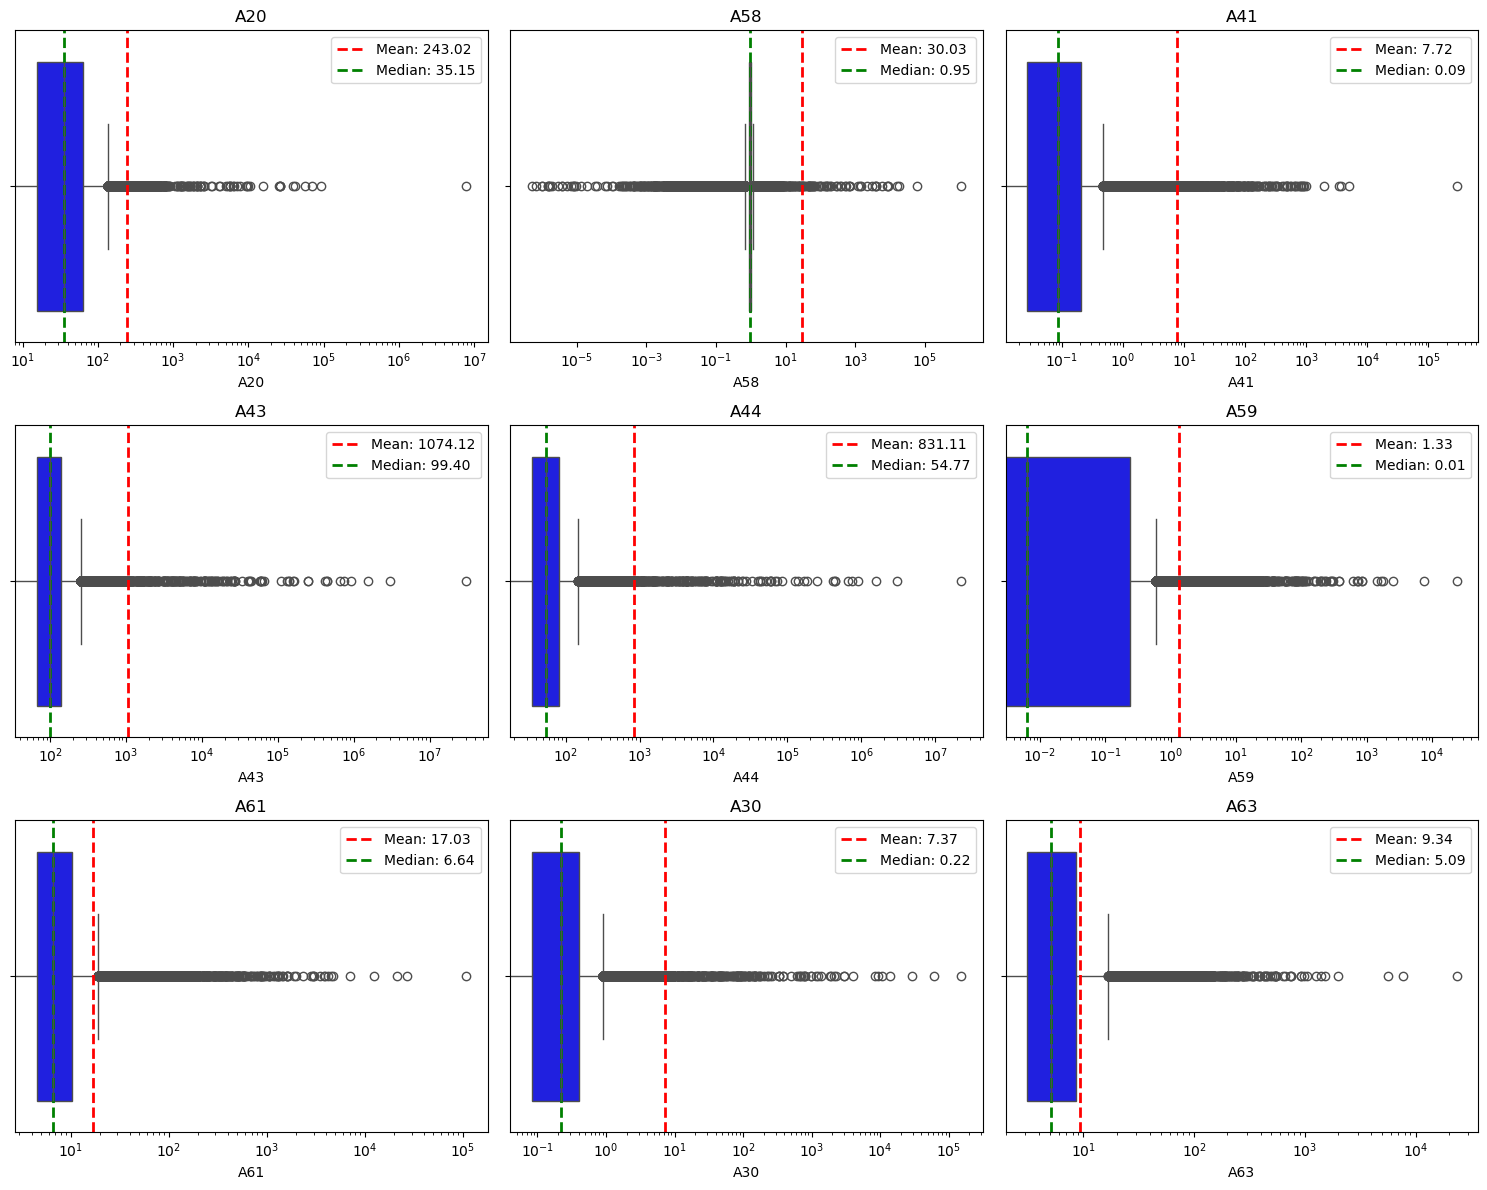

In [ ]:
# Wybór 9 zmiennych o najwyższej skośności
top9_skew = summary_stats['skew'].nlargest(9).index

# Tworzenie wykresów
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(top9_skew):
    ax = axes[i]
    sns.boxplot(x=original_data[col], ax=ax, color='blue')

    # Dodanie linii dla średniej i mediany
    mean_value = original_data[col].mean()
    median_value = original_data[col].median()
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

    ax.set_title(col)
    ax.legend()
    ax.set_xscale('log')  # Ustawienie skali logarytmicznej dla osi X

# Dopasowanie układu
plt.tight_layout()
plt.show()

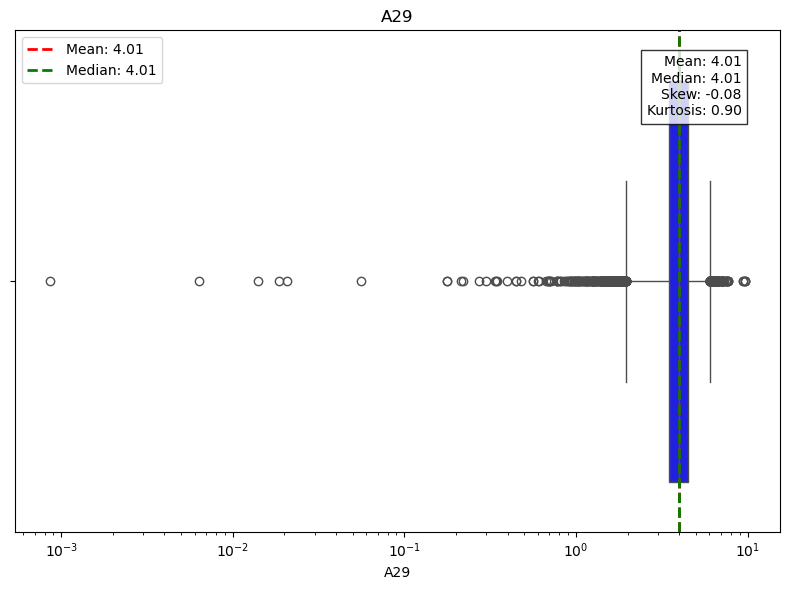

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis

# Tworzenie wykresu dla kolumny A29
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x=original_data['A29'], ax=ax, color='blue')

# Obliczenie statystyk
mean_value = original_data['A29'].mean()
median_value = original_data['A29'].median()
skew_value = skew(original_data['A29'], nan_policy='omit')
kurtosis_value = kurtosis(original_data['A29'], nan_policy='omit')

# Dodanie linii dla średniej i mediany
ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
ax.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Dodanie chmurki z wartościami średniej, mediany, skośności i kurtozy
text_str = f'Mean: {mean_value:.2f}\nMedian: {median_value:.2f}\nSkew: {skew_value:.2f}\nKurtosis: {kurtosis_value:.2f}'
ax.text(0.95, 0.95, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

ax.set_title('A29')
ax.legend()
ax.set_xscale('log')  # Ustawienie skali logarytmicznej dla osi X

# Wyświetlenie wykresu
plt.tight_layout()
plt.show()


Podsumowanie rozkładów danych

Żadna z kolumn nie ma rozkładu normalnego - wszystkie oprócz A29 mają rozkład leptokurtyczny co oznacza bardzo duże skupienie wartości wokół średnich ale też bardzo wysokie wartości ekstremalne. Wszystkie także oprócz A29 są skośne (8 lewo a reszta prawoskośna).

A29 jest też jedyną kolumną o której można powiedzieć że jej wartości niemal nie są skośne, jest też jedyną cechą o kurtozie mezokurtycznej.

O wysokim rozproszeniu danych wskazuje to że wszystkie oprócz A29 kolumn mają odchylenie standardowe większe od średniej (czasem wielokrotność w tysiącach).

Wytłumaczeniem rozkładów może być to że dane dotyczą firm o różnych wielkościach, skali biznesu, type itd. Wskaźniki małej 10 osobowej firmy będą zupełnie inne niż np Idea Banku czy GetBacku. Nie wiemy też czy miary w kolumnach są pierwotne czy są to może jakieś KPI i w jaki sposób liczone.

Ponieważ jednak są to dane zebrane i udostępnione przez wiarygodną (raczej) instytucję przyjmuję że są poprawne a nie są wynikiem błędu i je zostawiam takimi jakie są.

# Preprocessing danych

## Zaadresowanie kwestii wartości pustych

Znaczenie
- trzeba uzupełnić bo braki mają wpływ na korelacje między cechami które chce wykorzystać jako jedną z metod
- metoda uzupełnienia jest ważna bo ma wpływ na wariancje która jest wykorzystywana przez wiele metod redukcji np PCA

In [ ]:
# Wartości puste w wierszach
# Liczba wierszy w całym DataFrame
total_rows = original_data.shape[0]

# Liczba wierszy z brakującymi wartościami
rows_with_missing = original_data.isnull().any(axis=1).sum()

# Procent wierszy z brakami
percent_missing_rows = (rows_with_missing / total_rows) * 100

print(f"Liczba wierszy z brakami: {rows_with_missing}")
print(f"Procent wierszy z brakami: {percent_missing_rows:.2f}%")

Liczba wierszy z brakami: 23438
Procent wierszy z brakami: 54.00%


In [ ]:
# Wartości puste w kolumnach
# Obliczenie sumy brakujących wartości, procentu brakujących i wariancji
missing_values = original_data.isnull().sum()
missing_percentage = (missing_values / len(original_data)) * 100
variances = original_data.var()

# Tworzenie tabeli podsumowującej
summary_table = pd.DataFrame({
    'Suma_Pustych': missing_values,
    'Procent_Pustych': missing_percentage,
    'Wariancja': variances
})

# Filtrowanie i sortowanie po procencie pustych wartości malejąco
summary_table = summary_table.sort_values(by='Procent_Pustych', ascending=False)
summary_table.head(20)

,Suma_Pustych,Procent_Pustych,Wariancja
A37,18984,43.736897,9.353993e+06
A21,5854,13.486925,5.228948e+04
A27,2764,6.367930,1.225866e+09
A60,2152,4.957954,1.046238e+09
A45,2147,4.946435,5.896331e+06
A24,922,2.124179,6.381056e+01
A64,812,1.870752,5.613770e+06
A53,812,1.870752,1.473306e+06
A28,812,1.870752,2.355262e+04
A54,812,1.870752,1.490558e+06


In [ ]:
# Wartości puste wypełniam zerem bo wypełnianie ich wartościami np medianą zakłamywałoby rzeczywistość. Uznaję rzetelność i wiarygodność organizacji publikującej wyniki.
original_data_filled = original_data.fillna(0)

In [ ]:
# Test czy wszystkie NaN zostały usunięte
original_data_filled.isnull().sum()

A1       0
A2       0
A3       0
A4       0
A5       0
        ..
A62      0
A63      0
A64      0
class    0
year     0
Length: 66, dtype: int64

## Skalowanie danych

In [ ]:
# PCA i autenkodery wymagają skalowania , pozostałym metodą nie przeszkadza
# Podział na cechy i target
X = original_data_filled.drop(columns=['class'])
y = original_data_filled['class']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Skalowanie wykonujemy tylko na zbiorze treningowym, a następnie transformujemy testowy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Informacje diagnostyczne
print(f"Rozmiar zbioru treningowego po skalowaniu: {X_train_scaled.shape}")
print(f"Rozmiar zbioru testowego po skalowaniu: {X_test_scaled.shape}")


Rozmiar zbioru treningowego po skalowaniu: (34724, 65)
Rozmiar zbioru testowego po skalowaniu: (8681, 65)


In [ ]:
X_test_scaled

array([[ 4.48779170e-02, -5.51055995e-02,  5.81427697e-02, ...,
        -9.50275859e-03, -2.70058230e-02,  4.45339923e-02],
       [-7.72891932e-02,  9.87353515e-02,  1.39526347e-02, ...,
        -1.04886827e-01, -2.20821571e-02, -7.34115730e-01],
       [-7.59467198e-03,  3.68793092e-02, -3.84901913e-02, ...,
        -7.31822188e-02, -2.77608463e-02, -7.34115730e-01],
       ...,
       [ 7.67193974e-02, -5.53902300e-02,  7.46986641e-02, ...,
        -2.76547740e-02, -2.71712485e-02,  4.45339923e-02],
       [ 5.67382231e-02, -9.24177623e-03, -1.23942895e-03, ...,
        -1.37705178e-02, -2.77620657e-02, -1.51276545e+00],
       [-4.83410629e-03,  3.97675787e-02, -6.93562055e-02, ...,
        -1.25822011e-01, -2.92732911e-02,  4.45339923e-02]])

## Balansowanie targetu

In [ ]:
#Dane są silnie niezbalansowane co może wpłynąć na wyniki niektórych metod redukcji ( feature importance, autoencoder) dlatego je balansuje na tym etapie

# Balansowanie danych treningowych za pomocą SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Sprawdzenie efektów balansowania
print(f"Zbiór treningowy: {X_train.shape}, Zbiór testowy: {X_test.shape}")
print(f"Rozmiar danych przed SMOTE: {X_train.shape}, {y_train.value_counts()}")
print(f"Rozmiar danych po SMOTE: {X_train_balanced.shape}, {y_train_balanced.value_counts()}")

Zbiór treningowy: (34724, 65), Zbiór testowy: (8681, 65)
Rozmiar danych przed SMOTE: (34724, 65), class
0    33051
1     1673
Name: count, dtype: int64
Rozmiar danych po SMOTE: (66102, 65), class
0    33051
1    33051
Name: count, dtype: int64


In [ ]:
# Sprawdzenie liczności klas przed SMOTE
print("Liczność klas przed SMOTE:")
print(pd.Series(y_train).value_counts())

# Balansowanie danych treningowych za pomocą SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Sprawdzenie liczności klas po SMOTE
print("\nLiczność klas po SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Sprawdzenie NaN po SMOTE
print("\nLiczba NaN po SMOTE:", np.isnan(X_train_balanced).sum())


Liczność klas przed SMOTE:
class
0    33051
1     1673
Name: count, dtype: int64

Liczność klas po SMOTE:
class
0    33051
1    33051
Name: count, dtype: int64

Liczba NaN po SMOTE: 0


## Założenie słownika datasetów

In [ ]:
# Słownik na zestawy danych dla każdej metody redukcji wymiarowości
reduced_datasets = {}

In [ ]:
# Sprawdzenie kształtu danych przed zapisaniem
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")
print(f"y_test shape: {y_test.shape}")

# Zapisanie niezredukowanego datasetu jako punkt odniesienia
reduced_datasets['bazowy_nieredukowany'] = {
    'X_train': X_train_balanced,
    'X_test': X_test_scaled,
    'y_train': y_train_balanced,
    'y_test': y_test
}


X_train_balanced shape: (66102, 65)
X_test_scaled shape: (8681, 65)
y_train_balanced shape: (66102,)
y_test shape: (8681,)


# Metody redukcji wymiarowości

## Redukcja manualna

In [ ]:
# Zmniejszam zestaw poprzez usunięcie cech silnie skorelowanych oraz o niskiej wariancji¶

In [ ]:
# Zamiana numpy na dataframe
X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X.columns)

# Obliczenie korelacji
korelacja = X_train_balanced_df.corr()

# Obliczenie wariancji dla każdej kolumny
wariancja = X_train_balanced_df.var()

# Przekształcenie macierzy korelacji w długą formatkę
korelacja_tabela = korelacja.stack().reset_index()
korelacja_tabela.columns = ['Kolumna1', 'Kolumna2', 'Korelacja']

# Usunięcie korelacji własnych oraz duplikatów
korelacja_tabela = korelacja_tabela[korelacja_tabela['Kolumna1'] != korelacja_tabela['Kolumna2']]
korelacja_tabela = korelacja_tabela.drop_duplicates(subset=['Korelacja'], keep='first')

# Filtrowanie dla korelacji powyżej 0.9 lub poniżej -0.9
korelacja_tabela = korelacja_tabela[(korelacja_tabela['Korelacja'] > 0.9) | (korelacja_tabela['Korelacja'] < -0.9)]

# Dodanie kolumn z wariancją
korelacja_tabela['Wariancja_Kolumna1'] = korelacja_tabela['Kolumna1'].map(wariancja)
korelacja_tabela['Wariancja_Kolumna2'] = korelacja_tabela['Kolumna2'].map(wariancja)

korelacja_tabela

,Kolumna1,Kolumna2,Korelacja,Wariancja_Kolumna1,Wariancja_Kolumna2
10,A1,A11,0.922613,3.084097,2.060586
21,A1,A22,0.931427,3.084097,2.093573
47,A1,A48,0.950315,3.084097,2.574883
67,A2,A3,-0.986151,4.715306,5.498359
70,A2,A6,-0.905840,4.715306,3.544730
...,...,...,...,...,...
3177,A49,A58,-0.947165,0.537540,0.525326
3433,A53,A54,0.999365,1.129077,1.130384
3443,A53,A64,0.952232,1.129077,0.892435
3508,A54,A64,0.952715,1.130384,0.892435


In [ ]:
# Ponieważ zauważyłem że kolumny pojawiąją się więcej niż w jednej parze (patrz A1) zliczam dla każdej kolumny jej korelacje
silne_korelacje = korelacja_tabela.groupby('Kolumna1').size().reset_index(name='Silnie_Skorelowane')

# Filtrowanie dla kolumn mających więcej niż 1 silną korelację
silne_korelacje_filtered = silne_korelacje[silne_korelacje['Silnie_Skorelowane'] > 1]

# Posortowanie tabeli według liczby silnych korelacji w kolejności malejącej
silne_korelacje_sorted = silne_korelacje_filtered.sort_values(by='Silnie_Skorelowane', ascending=False)
silne_korelacje_sorted

,Kolumna1,Silnie_Skorelowane
9,A20,5
2,A11,5
25,A7,5
14,A30,4
18,A43,4
4,A14,3
8,A2,3
19,A44,3
0,A1,3
3,A12,2


In [ ]:
# W zestawie są grupy skorelowanych silnie cech - wybieram dla każdej grupy reprezentanta z najwyższą wariancją

In [ ]:
# Zestaw cech do usunięcia
features_to_remove = set()

# Iteracja i ustalenie które cechy mają niższe wariancje
for _, row in korelacja_tabela.iterrows():
    if row['Wariancja_Kolumna1'] > row['Wariancja_Kolumna2']:
        features_to_remove.add(row['Kolumna2'])  # Remove the feature with lower variance
    else:
        features_to_remove.add(row['Kolumna1'])  # Remove the second feature

# Usunięcie cech z X_train_balanced_df
X_train_reduced_manual = X_train_balanced_df.drop(columns=features_to_remove)

# Dopasowanie zestawu testowego
X_test_balanced_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_test_reduced_manual = X_test_balanced_df.drop(columns=features_to_remove)

# Podsumowanie
print(f"Removed {len(features_to_remove)} features: {features_to_remove}")
print(f"Number of features after reduction: {X_train_reduced_manual.shape[1]}")

# Zapis zestawów do słownika
reduced_datasets['manual_correlation'] = {
    'X_train': X_train_reduced_manual.values,
    'X_test': X_test_reduced_manual.values,
    'y_train': y_train_balanced,
    'y_test': y_test
}


Removed 30 features: {'A48', 'A44', 'A7', 'A14', 'A6', 'A50', 'A35', 'A26', 'A3', 'A20', 'A9', 'A30', 'A31', 'A53', 'A38', 'A11', 'A62', 'A10', 'A56', 'A16', 'A64', 'A2', 'A18', 'A58', 'A19', 'A63', 'A17', 'A22', 'A46', 'A43'}
Number of features after reduction: 35


## Feature Importance

In [ ]:
# Używam XGBboosta do oceny ważności każdej z kolumn

In [ ]:
# Tworzenie spójnych nazw cech dla obu zbiorów
feature_names = [f'Feature_{i}' for i in range(X_train_balanced.shape[1])]
X_train_balanced = pd.DataFrame(X_train_balanced, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Trenowanie modelu XGBoost na danych
model = XGBClassifier(random_state=42, eval_metric='logloss')
model.fit(X_train_balanced, y_train_balanced)

# Ważność cech
feature_importance = model.feature_importances_

# Tworzenie DataFrame z nazwami cech i ich ważnością
importance_df = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': feature_importance
})

# Sortowanie cech według ważności
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(20)

,Feature,Importance
25,Feature_25,0.202448
5,Feature_5,0.039792
21,Feature_21,0.039191
20,Feature_20,0.034042
37,Feature_37,0.032251
33,Feature_33,0.027435
38,Feature_38,0.027345
36,Feature_36,0.027144
26,Feature_26,0.025332
12,Feature_12,0.024552


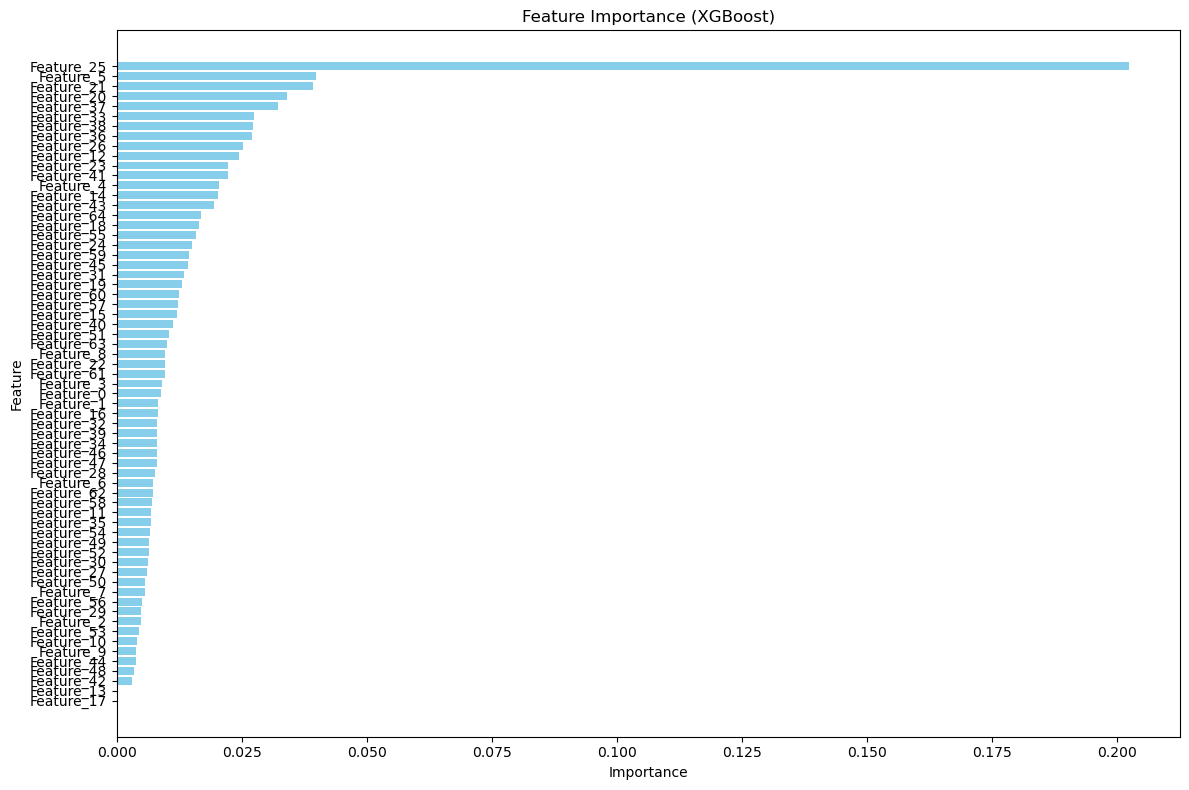

In [ ]:
# Wykres ważności cech
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Odwrócenie osi Y, aby najważniejsza cecha była na górze
plt.tight_layout()
plt.show()


In [ ]:
# Obliczanie skumulowanej ważności cech oraz stworzenie data setu z cechami odpowiadającymi za 95% decyzji modelu
cumulative_importance_95 = importance_df['Importance'].cumsum()

# Wybranie cech, które zachowują 95% ważności
selected_features_95 = importance_df.loc[cumulative_importance_95 <= 0.95, 'Feature'].tolist()

# Dopasowanie testowego wymiaru
X_train_reduced_fi_95 = X_train_balanced[selected_features_95]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_balanced.columns)
X_test_reduced_fi_95 = X_test_scaled_df[selected_features_95]

# Zapisanie zredukowanych zbiorów danych do słownika
reduced_datasets['feature_importance_95'] = {
    'X_train': X_train_reduced_fi_95.values,
    'X_test': X_test_reduced_fi_95.values,
    'y_train': y_train_balanced,
    'y_test': y_test
}

# Informacje diagnostyczne
print(f"Liczba cech przed redukcją: {X_train_balanced.shape[1]}")
print(f"Liczba cech po redukcji (95% ważności): {X_train_reduced_fi_95.shape[1]}")


Liczba cech przed redukcją: 65
Liczba cech po redukcji (95% ważności): 51


In [ ]:
# Tu to samo ale dla 90% - robię to z ciekawośći jaki wpływ może mieć takie 5%
cumulative_importance_90 = importance_df['Importance'].cumsum()

# Wybranie cech, które zachowują 95% ważności
selected_features_90 = importance_df.loc[cumulative_importance_90 <= 0.9, 'Feature'].tolist()

# Dopasowanie testowego wymiaru
X_train_reduced_fi_90 = X_train_balanced[selected_features_90]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_balanced.columns)
X_test_reduced_fi_90 = X_test_scaled_df[selected_features_90]

# Zapisanie zredukowanych zbiorów danych do słownika
reduced_datasets['feature_importance_90'] = {
    'X_train': X_train_reduced_fi_90.values,
    'X_test': X_test_reduced_fi_90.values,
    'y_train': y_train_balanced,
    'y_test': y_test
}

# Informacje diagnostyczne
print(f"Liczba cech przed redukcją: {X_train_balanced.shape[1]}")
print(f"Liczba cech po redukcji (90% ważności): {X_train_reduced_fi_90.shape[1]}")


Liczba cech przed redukcją: 65
Liczba cech po redukcji (90% ważności): 44


## PCA

In [ ]:
# Inicjalizacja PCA
pca = PCA()

# Dopasowanie PCA do danych
pca.fit(X_train_balanced)

# Transformacja danych na przestrzeń głównych składowych
X_pca = pca.transform(X_train_balanced)

# Suma wyjaśnionej wariancji
sum(pca.explained_variance_ratio_)

0.9999999999999999

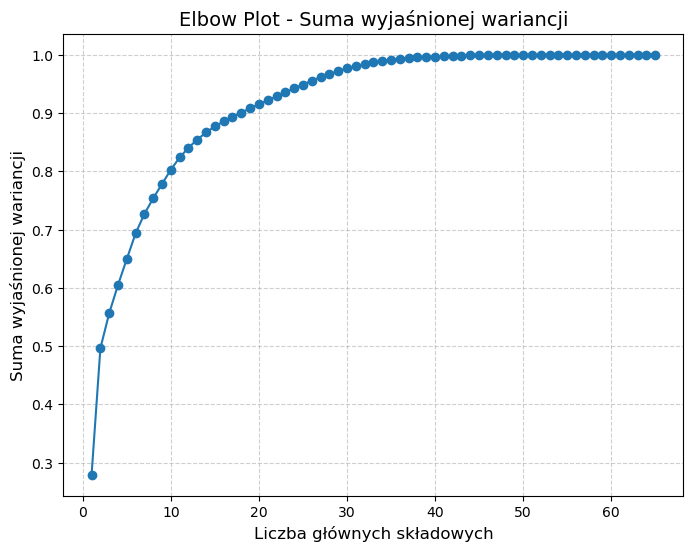

In [ ]:
# pca.explained_variance_ratio_ to lista proporcji wyjaśnionej wariancji przez każdą składową
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Wykres wariancji wyjaśnianej przez każdą składową
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Opis osi
plt.xlabel('Liczba głównych składowych', fontsize=12)
plt.ylabel('Suma wyjaśnionej wariancji', fontsize=12)
plt.title('Elbow Plot - Suma wyjaśnionej wariancji', fontsize=14)

# Dodanie siatki (skali)
plt.grid(True, linestyle='--', alpha=0.6)

# Wyświetlenie wykresu
plt.show()

In [ ]:
# Przygotowanie tabeli z trzema kolumnami: składowa, wyjaśniona wariancja, skumulowana wariancja
sorted_indices = np.argsort(-pca.explained_variance_ratio_)  # Indeksy posortowane malejąco wg wariancji

# Posortowana wyjaśniona wariancja i wariancja skumulowana
sorted_variance_ratio = pca.explained_variance_ratio_[sorted_indices]
sorted_cumulative_variance = np.cumsum(sorted_variance_ratio)

# Tworzenie tabeli DataFrame
components_summary = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in sorted_indices],  # Numeracja składowych
    "Explained Variance": sorted_variance_ratio,
    "Cumulative Variance": sorted_cumulative_variance
})

components_summary.head(30)

,Component,Explained Variance,Cumulative Variance
0,PC1,0.279198,0.279198
1,PC2,0.217048,0.496247
2,PC3,0.060133,0.556379
3,PC4,0.048474,0.604854
4,PC5,0.044696,0.649549
5,PC6,0.043890,0.693440
6,PC7,0.033413,0.726852
7,PC8,0.026831,0.753684
8,PC9,0.024562,0.778245
9,PC10,0.024430,0.802675


In [ ]:
# Znalezienie liczby głównych składowych, które wyjaśniają 95% wariancji
threshold = 0.95
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= threshold) + 1

# Wybranie odpowiednich głównych składowych
selected_components = pca.components_[:num_components]
selected_variance_ratio = pca.explained_variance_ratio_[:num_components]
selected_cumulative_variance = cumulative_variance[:num_components]

# Tworzenie DataFrame z informacjami o składowych
components_95_summary = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(num_components)],
    "Explained Variance": selected_variance_ratio,
    "Cumulative Variance": selected_cumulative_variance
})

# Konwersja X_test_scaled na DataFrame
if isinstance(X_train_balanced, pd.DataFrame):
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train_balanced.columns)

# Transformacja danych PCA
X_train_pca = pca.transform(X_train_balanced)[:, :num_components]
X_test_pca = pca.transform(X_test_scaled)[:, :num_components]

# Sprawdzenie wymiarów wynikowych
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

# Zapisanie zredukowanych zbiorów danych do słownika
reduced_datasets['PCA_95'] = {
    'X_train': X_train_pca,
    'X_test': X_test_pca,
    'y_train': y_train_balanced,
    'y_test': y_test
}


X_train_pca shape: (66102, 26)
X_test_pca shape: (8681, 26)


In [ ]:
# Znalezienie liczby głównych składowych, które wyjaśniają 95% wariancji
threshold = 0.90
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= threshold) + 1

# Wybranie odpowiednich głównych składowych
selected_components = pca.components_[:num_components]
selected_variance_ratio = pca.explained_variance_ratio_[:num_components]
selected_cumulative_variance = cumulative_variance[:num_components]

# Tworzenie DataFrame z informacjami o składowych
components_90_summary = pd.DataFrame({
    "Component": [f"PC{i+1}" for i in range(num_components)],
    "Explained Variance": selected_variance_ratio,
    "Cumulative Variance": selected_cumulative_variance
})

# Konwersja X_test_scaled na DataFrame
if isinstance(X_train_balanced, pd.DataFrame):
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train_balanced.columns)

# Transformacja danych PCA
X_train_pca_90 = pca.transform(X_train_balanced)[:, :num_components]
X_test_pca_90 = pca.transform(X_test_scaled)[:, :num_components]

# Sprawdzenie wymiarów wynikowych
print(f"X_train_pca shape: {X_train_pca_90.shape}")
print(f"X_test_pca shape: {X_test_pca_90.shape}")

# Zapisanie zredukowanych zbiorów danych do słownika
reduced_datasets['PCA_90'] = {
    'X_train': X_train_pca,
    'X_test': X_test_pca,
    'y_train': y_train_balanced,
    'y_test': y_test
}


X_train_pca shape: (66102, 18)
X_test_pca shape: (8681, 18)


## AUTOENCODER

In [ ]:
# Rozmiar danych wejściowych
input_dim = X_train_balanced.shape[1]

# Rozmiar przestrzeni latentnej
latent_dim = 16  # Zmniejszona przestrzeń latentna

# Warstwa wejściowa
input_layer = Input(shape=(input_dim,))

# Encoder z regularizacją
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)  # Regularizacja dropout
encoder = Dense(32, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)
latent_space = Dense(latent_dim, activation='tanh')(encoder)

# Wyjście klasyfikacyjne (predykcja y)
classifier_output = Dense(1, activation='sigmoid')(latent_space)

# Model tylko dla klasyfikacji (bez dekodowania)
classifier_autoencoder = Model(inputs=input_layer, outputs=classifier_output)

# Kompilacja modelu
classifier_autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Skupiamy się na klasyfikacji
    metrics=['accuracy', 'Recall']  # Śledzimy także Recall
)

# Trenowanie modelu
history = classifier_autoencoder.fit(
    X_train_balanced,
    y_train_balanced,  # Wyjście to tylko predykcja y
    epochs=50,
    batch_size=32,
    validation_split=0.2  # Użycie części danych treningowych jako walidacyjnych
)

# Model enkodera (do redukcji wymiarów)
encoder_model = Model(inputs=input_layer, outputs=latent_space)

# Przekształcenie danych do przestrzeni latentnej
X_train_reduced_sa = encoder_model.predict(X_train_balanced)
X_test_reduced_sa = encoder_model.predict(X_test_scaled)

# Skalowanie przestrzeni latentnej
scaler = StandardScaler()
X_train_reduced_sa_scaled = scaler.fit_transform(X_train_reduced_sa)
X_test_reduced_sa_scaled = scaler.transform(X_test_reduced_sa)

# Zapis przetworzonych danych do słownika
reduced_datasets['supervised_autoencoder_16'] = {
    'X_train': X_train_reduced_sa_scaled,
    'y_train': y_train_balanced,
    'X_test': X_test_reduced_sa_scaled,
    'y_test': y_test
}


Epoch 1/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.3309 - accuracy: 0.6741 - loss: 0.5976 - val_Recall: 0.4991 - val_accuracy: 0.4991 - val_loss: 0.8090
Epoch 2/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.5820 - accuracy: 0.7212 - loss: 0.5303 - val_Recall: 0.5917 - val_accuracy: 0.5917 - val_loss: 0.7317
Epoch 3/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.6118 - accuracy: 0.7438 - loss: 0.4999 - val_Recall: 0.6757 - val_accuracy: 0.6757 - val_loss: 0.6603
Epoch 4/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.6536 - accuracy: 0.7605 - loss: 0.4783 - val_Recall: 0.6916 - val_accuracy: 0.6916 - val_loss: 0.6323
Epoch 5/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.6808 - accuracy: 0.7762 - loss: 0.4619 - val_Recall: 0.6902 - val_accuracy: 0.6902 - val_loss: 0.6306
Epoch 6/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.6959 - accuracy: 0.7856 - loss: 0.4445 - val_Recall: 0.7176 - val_accuracy: 0.7176 - val_loss:

In [ ]:
# Rozmiar danych wejściowych
input_dim = X_train_balanced.shape[1]

# Rozmiar przestrzeni latentnej
latent_dim = 8  # Zmniejszona przestrzeń latentna

# Warstwa wejściowa
input_layer = Input(shape=(input_dim,))

# Encoder z regularizacją
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)  # Regularizacja dropout
encoder = Dense(32, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)
latent_space = Dense(latent_dim, activation='tanh')(encoder)

# Wyjście klasyfikacyjne (predykcja y)
classifier_output = Dense(1, activation='sigmoid')(latent_space)

# Model tylko dla klasyfikacji (bez dekodowania)
classifier_autoencoder = Model(inputs=input_layer, outputs=classifier_output)

# Kompilacja modelu
classifier_autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Skupiamy się na klasyfikacji
    metrics=['accuracy', 'Recall']  # Śledzimy także Recall
)

# Trenowanie modelu
history = classifier_autoencoder.fit(
    X_train_balanced,
    y_train_balanced,  # Wyjście to tylko predykcja y
    epochs=50,
    batch_size=32,
    validation_split=0.2  # Użycie części danych treningowych jako walidacyjnych
)

# Model enkodera (do redukcji wymiarów)
encoder_model = Model(inputs=input_layer, outputs=latent_space)

# Przekształcenie danych do przestrzeni latentnej
X_train_reduced_sa = encoder_model.predict(X_train_balanced)
X_test_reduced_sa = encoder_model.predict(X_test_scaled)

# Skalowanie przestrzeni latentnej
scaler = StandardScaler()
X_train_reduced_sa_scaled = scaler.fit_transform(X_train_reduced_sa)
X_test_reduced_sa_scaled = scaler.transform(X_test_reduced_sa)

# Zapis przetworzonych danych do słownika
reduced_datasets['supervised_autoencoder_8'] = {
    'X_train': X_train_reduced_sa_scaled,
    'y_train': y_train_balanced,
    'X_test': X_test_reduced_sa_scaled,
    'y_test': y_test
}


Epoch 1/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - Recall: 0.3426 - accuracy: 0.6691 - loss: 0.5991 - val_Recall: 0.5587 - val_accuracy: 0.5587 - val_loss: 0.7627
Epoch 2/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.5726 - accuracy: 0.7165 - loss: 0.5360 - val_Recall: 0.6490 - val_accuracy: 0.6490 - val_loss: 0.7330
Epoch 3/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.6455 - accuracy: 0.7394 - loss: 0.5040 - val_Recall: 0.7124 - val_accuracy: 0.7124 - val_loss: 0.6243
Epoch 4/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.6770 - accuracy: 0.7589 - loss: 0.4790 - val_Recall: 0.7134 - val_accuracy: 0.7134 - val_loss: 0.6382
Epoch 5/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.7076 - accuracy: 0.7758 - loss: 0.4589 - val_Recall: 0.6970 - val_accuracy: 0.6970 - val_loss: 0.6397
Epoch 6/50
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Recall: 0.7277 - accuracy: 0.7939 - loss: 0.4375 - val_Recall: 0.8061 - val_accuracy: 0.8061 - val_loss:

# Trenowanie modelu

In [ ]:
# Słownik na metryki
metrics = []

for dataset_name, dataset in reduced_datasets.items():
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']

    num_features = X_train.shape[1]

    results = {
        "Dataset": dataset_name,
        "Train Accuracy": [],
        "Test Accuracy": [],
        "Train Precision": [],
        "Test Precision": [],
        "Train Recall": [],
        "Test Recall": [],
        "Train F1 Score": [],
        "Test F1 Score": [],
        "CPU Usage (%)": [],
        "RAM Usage (MB)": [],
        "Training Time (s)": [],
        "Number of Features": num_features
    }

    for _ in range(30):
        # Monitorowanie zasobów
        start_time = time.time()

        # Monitorowanie CPU i RAM przed treningiem
        cpu_usage_before = psutil.cpu_percent(interval=1)
        ram_usage_before = psutil.virtual_memory().used / (1024 ** 2)

        # Trenowanie modelu
        xgb_model = xgboost.XGBClassifier(eval_metric='logloss', random_state=None)
        xgb_model.fit(X_train, y_train)

        # Monitorowanie CPU i RAM po treningu
        cpu_usage_after = psutil.cpu_percent(interval=1)
        ram_usage_after = psutil.virtual_memory().used / (1024 ** 2)

        # Obliczanie czasu treningu
        training_time = time.time() - start_time

        # Ewaluacja na zbiorze treningowym i testowym
        y_train_pred = xgb_model.predict(X_train)
        y_test_pred = xgb_model.predict(X_test)
        y_train_pred_proba = xgb_model.predict_proba(X_train)
        y_test_pred_proba = xgb_model.predict_proba(X_test)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        train_precision = precision_score(y_train, y_train_pred, average='macro')
        test_precision = precision_score(y_test, y_test_pred, average='macro')

        train_recall = recall_score(y_train, y_train_pred, average='macro')
        test_recall = recall_score(y_test, y_test_pred, average='macro')

        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        # Zbieranie wyników
        results["Train Accuracy"].append(train_accuracy)
        results["Test Accuracy"].append(test_accuracy)
        results["Train Precision"].append(train_precision)
        results["Test Precision"].append(test_precision)
        results["Train Recall"].append(train_recall)
        results["Test Recall"].append(test_recall)
        results["Train F1 Score"].append(train_f1)
        results["Test F1 Score"].append(test_f1)
        results["CPU Usage (%)"].append(max(0, cpu_usage_after - cpu_usage_before))
        results["RAM Usage (MB)"].append(max(0, ram_usage_after - ram_usage_before))
        results["Training Time (s)"].append(training_time)

    # Uśrednianie wyników
    metrics.append({
        "Dataset": dataset_name,
        "Train Recall": round(np.mean(results["Train Recall"]), 2),
        "Test Recall": round(np.mean(results["Test Recall"]), 2),
        "Train Precision": round(np.mean(results["Train Precision"]), 2),
        "Test Precision": round(np.mean(results["Test Precision"]), 2),
        "Train F1 Score": round(np.mean(results["Train F1 Score"]), 2),
        "Test F1 Score": round(np.mean(results["Test F1 Score"]), 2),
        "Train Accuracy": round(np.mean(results["Train Accuracy"]), 2),
        "Test Accuracy": round(np.mean(results["Test Accuracy"]), 2),
        "Recall Diff (%)": round(((np.mean(results["Train Recall"]) - np.mean(results["Test Recall"])) / np.mean(results["Train Recall"])) * 100, 2),
        "Precision Diff (%)": round(((np.mean(results["Train Precision"]) - np.mean(results["Test Precision"])) / np.mean(results["Train Precision"])) * 100, 2),
        "Accuracy Diff (%)": round(((np.mean(results["Train Accuracy"]) - np.mean(results["Test Accuracy"])) / np.mean(results["Train Accuracy"])) * 100, 2),
        "F1 Score Diff (%)": round(((np.mean(results["Train F1 Score"]) - np.mean(results["Test F1 Score"])) / np.mean(results["Train F1 Score"])) * 100, 2),
        "CPU Usage (%)": round(np.mean(results["CPU Usage (%)"]), 2),
        "RAM Usage (MB)": round(np.mean(results["RAM Usage (MB)"]), 2),
        "Training Time (s)": round(np.mean(results["Training Time (s)"]), 2),
        "Number of Features": num_features
    })

# Tworzenie DataFrame z wynikami
metrics_df = pd.DataFrame(metrics)
metrics_df


,Dataset,Train Recall,Test Recall,Train Precision,Test Precision,Train F1 Score,Test F1 Score,Train Accuracy,Test Accuracy,Recall Diff (%),Precision Diff (%),Accuracy Diff (%),F1 Score Diff (%),CPU Usage (%),RAM Usage (MB),Training Time (s),Number of Features
0,bazowy_nieredukowany,1.00,0.85,1.00,0.87,1.00,0.86,1.00,0.98,14.73,12.78,2.25,13.78,6.30,11.82,3.72,65
1,manual_correlation,0.99,0.78,0.99,0.75,0.99,0.77,0.99,0.96,21.20,23.87,3.64,22.61,7.86,6.12,2.91,35
2,feature_importance_95,1.00,0.86,1.00,0.87,1.00,0.86,1.00,0.97,14.28,13.11,2.27,13.71,6.05,1.62,3.28,51
3,feature_importance_90,1.00,0.85,1.00,0.87,1.00,0.86,1.00,0.97,14.48,12.97,2.24,13.75,7.45,3.94,3.15,44
4,PCA_95,0.94,0.60,0.94,0.53,0.94,0.53,0.94,0.83,36.21,42.98,11.15,42.94,7.01,3.12,2.76,26
5,PCA_90,0.94,0.60,0.94,0.53,0.94,0.53,0.94,0.83,36.21,42.98,11.15,42.94,7.97,2.40,2.80,26
6,supervised_autoencoder_16,0.95,0.75,0.95,0.60,0.95,0.63,0.95,0.88,20.43,36.42,6.99,33.19,7.61,2.01,2.48,16
7,supervised_autoencoder_8,0.93,0.75,0.93,0.60,0.93,0.63,0.93,0.88,19.19,35.45,5.66,32.16,7.77,2.62,2.34,8


# Analiza wyników i podsumowanie

## Wskaźniki jakości modelu

In [ ]:
# Wskaźniki jakości modelu
metrics_df[['Dataset', 'Test Recall','Test Precision', 'Test F1 Score','Test Accuracy']].sort_values( by = 'Test Recall', ascending = False)

,Dataset,Test Recall,Test Precision,Test F1 Score,Test Accuracy
2,feature_importance_95,0.86,0.87,0.86,0.97
0,bazowy_nieredukowany,0.85,0.87,0.86,0.98
3,feature_importance_90,0.85,0.87,0.86,0.97
1,manual_correlation,0.78,0.75,0.77,0.96
6,supervised_autoencoder_16,0.75,0.60,0.63,0.88
7,supervised_autoencoder_8,0.75,0.60,0.63,0.88
4,PCA_95,0.60,0.53,0.53,0.83
5,PCA_90,0.60,0.53,0.53,0.83


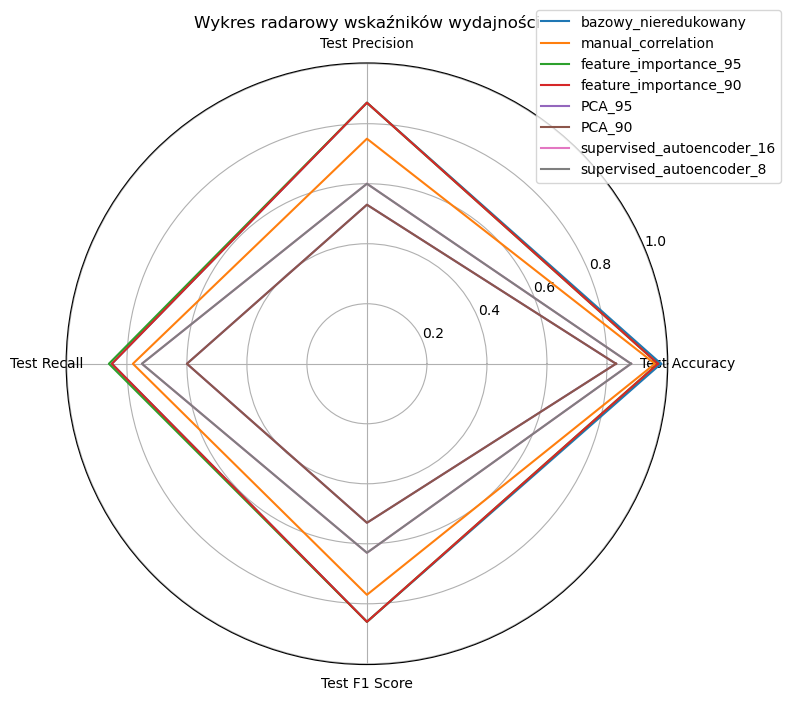

In [ ]:
# Kategorie do wykresu radarowego
kategorie = [ 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score']
N = len(kategorie)

# Obliczenie kątów dla osi
kąty = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
kąty += kąty[:1]  # Zamknięcie koła

# Inicjalizacja wykresu
plt.figure(figsize=(8, 8))

# Dodanie danych dla każdego zbioru
for i in range(len(metrics_df)):
    wartości = metrics_df.loc[i, kategorie].tolist()
    wartości += wartości[:1]  # Zamknięcie koła
    plt.polar(kąty, wartości, label=metrics_df['Dataset'][i])



# Ustawienia osi i tytułu
plt.xticks(kąty[:-1], kategorie)
plt.title('Wykres radarowy wskaźników wydajności')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

W oparciu o wyniki jakości modelu można zauważyć 3 grupy datasetów:
- oba feature importance i niezredukowany mają najwyższe wyniki a różnice między nimi są praktycznie żadne choć niezredukowany jest minimalnie gorszy od FI_95 pod względem recall i precision i od FI_90 pod względem precision
- zestawy powstałe w wyniku manualnej redukcji i encoderów mają wyraźnie niższe wyniki, encodery choć recall mają bardzo zbliżony do manualnego to jednak generują znacznie więcej fałszywych alarmów co znacząco odbija się na F1Score
- zdecydowanie najgorzej wypadają zestawy PCA których wskaźniki są o 30-40% gorsze niż Feature importance
- zestawy są albo ogólnie lepsze albo gorsze, nie ma dylematów w stylu precyzja za czułość itd

Interpretacja:
- zestawy z feature importance są skazane na sukces ponieważ są tworzone dokładnie wg tych samych zasad co końcowy model, już na wstępnym etapie odrzucone są mało informatywne cechy. Dla nich układem odniesienia jest właściwie zestaw niezredukowany. Wynika to z tego że poza kilkoma cechami których ważność jest bardzo wysoka to pozostałe pod względem ważności nie różnią się znacząco więc zestawy feature importance nie mają tych cech zdecydowanie mniej niż zestaw niezredukowany.
- druga grupa jest dla mnie zaskoczeniem bo spodziewałem się znacznie więcej po autoencoderach zwłaszcza że skoncentrowałem się nich na przygotowaniu zestawów pod klasyfikację. Wygląda jednak na to że znacznie słabiej określają cechy rzeczywiście istotne dla rozróżnienia klas niż feature importance. Czułość w ich wypadku ratuje niska precyzja. Z kolei manualna redukcja to pozytywne zaskoczenie, wygląda na to że najprostsza metoda ma wyniki niewiele słabsze od najlepszych. Ale może to być specyfika tego zestawu gdzie sporo cech jest ze sobą ściśle skorelowanych co nie wnosi dużo wartości informatywnej a może generować sporo szumu bo model szuka niuansowych różnic między nimi.
- kiedy przygotowywałem się do tego projektu wiedziałem że na pewno użyję PCA bo praktycznie za każdym razem kiedy napotykałem temat redukcji PCA było wymieniane w pierwszej kolejności jako podstawowa metoda. Jej wynik więc był zaskoczeniem i długo szukałem wyjaśnienie w błędnym kodzie itd. Ale wydaje mi się że wyjaśnieniem mogą być same dane a właściwie ich nieliniowość. PCA to metoda dla danych liniowych więc skoro inne metody które są wprost stworzone do nieliniowości jak sieci czy feature importance mają lepsze wyniki to dowodzi tego że taki jest ten zestaw. Próbowałem uruchomić Kernel PCA czyli PCA dla danych nieliniowych ale zabijał mi laptopa ;)

## Przeuczanie modelu

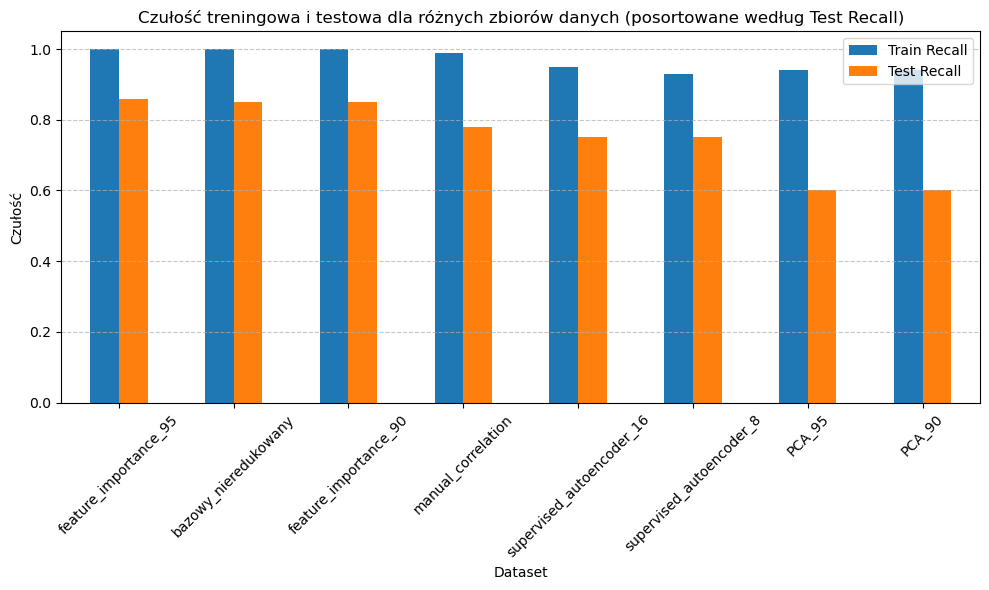

In [ ]:
import matplotlib.pyplot as plt

# Sortowanie według Test Recall
metrics_df_sorted = metrics_df.sort_values(by='Test Recall', ascending=False)

# Wykres słupkowy dla dokładności
metrics_df_sorted.plot(x='Dataset', y=['Train Recall', 'Test Recall'], kind='bar', figsize=(10, 6))
plt.title('Czułość treningowa i testowa dla różnych zbiorów danych (posortowane według Test Recall)')
plt.ylabel('Czułość')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt

In [ ]:
metrics_df[['Dataset', 'Recall Diff (%)', 'Precision Diff (%)', 'F1 Score Diff (%)','Accuracy Diff (%)']].sort_values( by = 'Recall Diff (%)')

,Dataset,Recall Diff (%),Precision Diff (%),F1 Score Diff (%),Accuracy Diff (%)
2,feature_importance_95,14.28,13.11,13.71,2.27
3,feature_importance_90,14.48,12.97,13.75,2.24
0,bazowy_nieredukowany,14.73,12.78,13.78,2.25
7,supervised_autoencoder_8,19.19,35.45,32.16,5.66
6,supervised_autoencoder_16,20.43,36.42,33.19,6.99
1,manual_correlation,21.20,23.87,22.61,3.64
4,PCA_95,36.21,42.98,42.94,11.15
5,PCA_90,36.21,42.98,42.94,11.15


Takie same grupy możemy wyłonić jeśli chodzi o redukcję szumu i mało istotnych cech. Także tutaj feature importance uzyskuje najlepsze wyniki a PCA najgorsze. Dwie rzeczy zwracają tutaj moją uwagę: zarówno encoder jak i PCA z mniejszą liczbą cech mają lepsze wyniki niż te z wyższą; wszystkie zestawy oprócz feature importance mają gorsze wyniki od bazowego, najbardziej zaszumionego zestawu.

Interpretacja:
Na wykresie ważności cech widać grupę cech bardzo istotnych i to jak później wazności się wypłaszcza dla wielu cech więc wyniki zestawu feature importance nie zaskakują. Wygląda na to że pozostałe metody poradziły sobie gorzej z ich rozróżnieniem i raczej zgubiły te cechy niż je zachowały. To może tłumaczyć lepszy wynik niezredukowanego zestawu od pozosotałych metod bo w nim te najważniejsze cechy na pewno są choć jednocześnie z największym szumem.

## Metryki sprzętowe

In [ ]:
metrics_df[['Dataset', 'Number of Features','CPU Usage (%)',
       'RAM Usage (MB)', 'Training Time (s)']].sort_values( by = 'CPU Usage (%)')

,Dataset,Number of Features,CPU Usage (%),RAM Usage (MB),Training Time (s)
2,feature_importance_95,51,6.05,1.62,3.28
0,bazowy_nieredukowany,65,6.30,11.82,3.72
4,PCA_95,26,7.01,3.12,2.76
3,feature_importance_90,44,7.45,3.94,3.15
6,supervised_autoencoder_16,16,7.61,2.01,2.48
7,supervised_autoencoder_8,8,7.77,2.62,2.34
1,manual_correlation,35,7.86,6.12,2.91
5,PCA_90,26,7.97,2.40,2.80


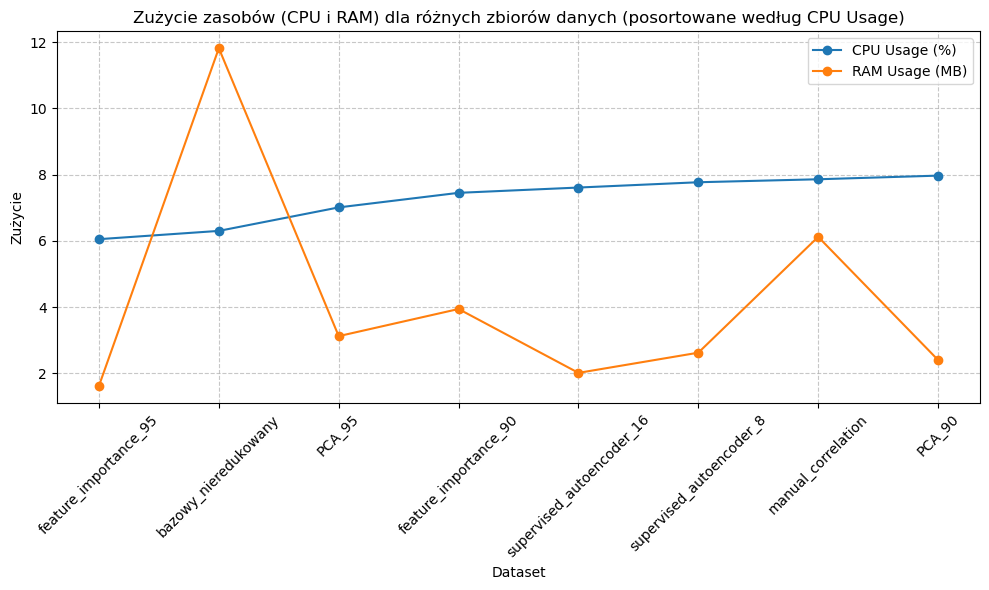

In [ ]:
# Sortowanie według CPU Usage (%)
metrics_df_sorted_cpu = metrics_df.sort_values(by='CPU Usage (%)', ascending=True)

# Wykres liniowy dla zużycia CPU i RAM
metrics_df_sorted_cpu.plot(x='Dataset', y=['CPU Usage (%)', 'RAM Usage (MB)'], kind='line', marker='o', figsize=(10, 6))
plt.title('Zużycie zasobów (CPU i RAM) dla różnych zbiorów danych (posortowane według CPU Usage)')
plt.ylabel('Zużycie')
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

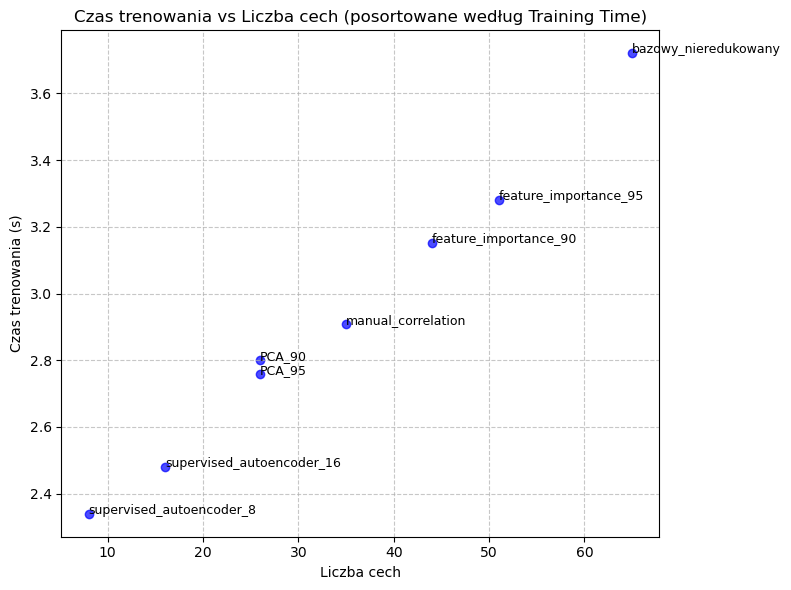

In [ ]:
import matplotlib.pyplot as plt

# Sortowanie według Training Time (s)
metrics_df_sorted_time = metrics_df.sort_values(by='Training Time (s)', ascending=True)

# Wykres punktowy (scatter plot) dla Czasu trenowania vs Liczba cech
plt.figure(figsize=(8, 6))
plt.scatter(metrics_df_sorted_time['Number of Features'], metrics_df_sorted_time['Training Time (s)'], c='blue', alpha=0.7)

# Dodanie etykiet dla punktów
for i, txt in enumerate(metrics_df_sorted_time['Dataset']):
    plt.annotate(txt, (metrics_df_sorted_time['Number of Features'].iloc[i], metrics_df_sorted_time['Training Time (s)'].iloc[i]), fontsize=9)

plt.title('Czas trenowania vs Liczba cech (posortowane według Training Time)')
plt.xlabel('Liczba cech')
plt.ylabel('Czas trenowania (s)')
plt.grid(alpha=0.7, linestyle='--')
plt.tight_layout()
plt.show()


Część ta jest dla mnie najtrudniejsza do zinterpretowania i zrozumienia. Ogólnie widać że kolejny raz feature importance jest w czołówce jeśli chodzi o GPU i RAM a PCA na końcu. Jedyne co mi przychodzi do głowy to że lepszy zestaw wymaga mniejszej liczby i głębokości drzew w XGBoost. Ogólnie różnice nie są jednak duże poza widoczną wyższą potrzebą pamięci RAM przez zestawy encoderowe. I to jest dziwne biorąc pod uwagę że to najmniejsze zestawy, z najmniejszą ilością cech i danych.

Jeśli chodzi o czas to widoczna jest prosta zależność liniowa między liczbą cech a czasem treningu.

# Podsumowanie

Temat redukcji wymiarowości po projekcie wydaje mi się znacznie bardziej złożony i 'nieliniowy' niż przed, ale też z tego względu znacznie bardziej ciekawy. Wymaga nie tylko 'klepania' kodu ale też zrozumienia danych i relacji między nimi oraz odniesienia tej wiedzy do celu projektu.

Kilka wniosków po jego zakończeniu:
- metoda redukcji powinna być dobrana do dalszego celu pracy z zestawem
- warto sprawdzić przed wyborem metody jakiego rodzaju zależności mamy w danych, czy są liniowe czy nie
- proste metody nie muszą prowadzić do gorszych wyników niż wyszukane
- jeśli dane nie są duże i skomplikowane a mamy zasoby redukcja wymiarowości może być warta wysiłku
- metody można łączyć np. grupy silnie skorelowanych cech spłaszyć do jednej za pomocą PCA a potem tak przygotowany zestaw przepuścić przez feature importance by wyłonić ostateczny kształt
- jest jeszcze jedno kryterium którego nie wymieniłem powyżej bo jest ono bardziej subiektywne to jest łatwość pracy z metodą i czas poświęcony na jej przeprowadzenie. Z moim niskim doświadczeniem na tym polu (poza klasyfikacją w XGBoost wszystkie pozostałe metody stosowałem pierwszy raz) ta ocena jest obciążana czasem jaki musiałem poświęcić na ich zrozumienie i przeprowadzenie. Na dzisiaj dla mnie kolejność łatwości/szybkości byłaby następująca: najszybszy XGBoost i feature importance, PCA, manualna redukcja i najtrudniejsze encodery. Te ostatnie też wymagają dużo zasobów i czasu na wytrenowanie modelu - niemal tyle co późniejsze wytrenowanie 70 modeli w XGBoost (7 zestawów po 10 razy)
- nigdy więcej nie wybiorę do pracy zestawu z zakodowanymi nazwami i bez rozumienia tego na co patrzę

Jako inwestor wybrałbym redukcję w oparciu o feature importance bo najlepsza, najszybsza i najtańsza w tym przypadku. Jako adept studiów wybieram zbadanie metod pod kątem klasyfikacji wielkoklasowej i regresji liniowej jako kolejne cele do nauki.  